# IIT BHU - Technex'17

In [1]:
#Importing libraries
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import xlrd
import math

from matplotlib import rcParams

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows',2000)

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#Reading the train and test file
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#Removing the index feature
train.drop('Serial',axis=1,inplace=True)
#test.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
#Renaming the columns
df = [train,test]
for data in df:
    data.rename(columns={'date':'Date','time of year':'Season','Day off':'Holiday',' Humidity':'Humidity'},inplace=True)

In [5]:
#Adding columns for Date and Month
for data in df:
    data['Dat'] = -1
    data['Month'] = -1
    for index,row in data.iterrows():
        y = row['Date']
        d = int(y[:2])
        m = int(y[3:5])
        data.set_value(index,'Dat',d)
        data.set_value(index,'Month',m)

In [6]:
#Temp and Feel_Temp highly correlated, diff. may help to a larger extent
for data in df:
    data['temp_diff'] = -1.0
    for index,row in data.iterrows():
        y = row['Feel_Temp']-row['Temp']
        data.set_value(index,'temp_diff',y)

In [7]:
#Creating dictionary for missing value imputation of Humidity using Season and Weather
sw = {}
for i in range(1,5): #Season
    for j in range(1,5): #Weather
        c = 0.0
        count = 0
        for data in df:
            for index,row in train.iterrows():
                if(row['Season']==i and row['Weather']==j and row['Humidity']>-150.0):
                    c = c + row['Humidity']
                    count = count + 1
            if(count>0):
                avg = c/count
                sw[(i,j,'train')] = avg
for i in range(1,5): #Season
    for j in range(1,5): #Weather
        c = 0.0
        count = 0
        for index,row in test.iterrows():
            if(row['Season']==i and row['Weather']==j and row['Humidity']>-150.0):
                c = c + row['Humidity']
                count = count + 1
        if(count>0):
            avg = c/count
            sw[(i,j,'test')] = avg

In [8]:
#Missing Value Imputation of Humidity
for i,data in enumerate(df):
    for index,row in data.iterrows():
        if(row['Humidity']==-200.0):
            s = row['Season']
            w = row['Weather']
            if(i==0):
                db = 'train'
            else:
                db = 'test'
            data.set_value(index,'Humidity',sw[(s,w,db)])

In [9]:
#Removing the date column
for data in df:
    data.drop('Date',axis=1,inplace=True)

In [10]:
#As only 3 rows for 4th Weather, change to 3 for ease
for data in df:
    for index,row in data.iterrows():
        if(row['Weather']==4):
            data.set_value(index,'Weather',3)

<b>Date:</b> In mm/dd/yyyy format<br>
<b>Season:</b> 4 quarters of year => 1 to 4<br>
<b>Year:</b> 0 for 2011, 1 for 2012<br>
<b>Month:</b> 1 to 12<br>
<b>Dat:</b> 1 to 31<br>
<b>Hour:</b> 0-23<br>
<b>Holiday:</b> Holiday or not<br>
<b>Weekday:</b> Day of the week from 0 to 6<br>
<b>Workingday:</b> Neither a weekend nor holiday<br>
<b>Weather:</b> 1 to 3<br>
<b>Temp:</b> Actual temperature<br>
<b>Feel_Temp:</b> "feel-like" temperature --- highly correlated with Temp<br>
<b>temp_diff:</b> Difference between actual and felt<br>
<b>Humidity:</b> Relative Humidity<br>
<b>Fog Density:</b> Extent of fog (Normalised)
### Approach:
We will model the local and foreign visitors separately because of the difference in their footfall patterns.

In [11]:
#Dividing train into local and foreign for different models
local = train.copy()
local.drop(['Foreigners','Total Visitors'],axis=1,inplace=True)
local_test = test.copy()

## Local Visitors

count    1393.000000
mean      140.142139
std       125.994674
min         0.000000
25%        36.000000
50%       111.000000
75%       212.000000
max       555.000000
Name: Local, dtype: float64
count    1332.000000
mean      145.982733
std       126.562293
min         1.000000
25%        34.000000
50%       121.500000
75%       218.000000
max       553.000000
Name: Local, dtype: float64


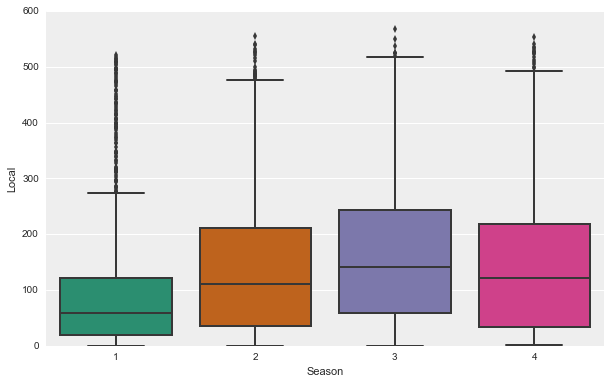

In [12]:
#Season
df_local = [local,local_test]
sns.boxplot(local['Season'],local['Local'])
print local[local['Season']==2]['Local'].describe()
print local[local['Season']==4]['Local'].describe()
for data in df_local:
    for index,row in data.iterrows(): #As 2 and 4 are almost similar, make them one!
        if(row['Season']==4):
            data.set_value(index,'Season',2)

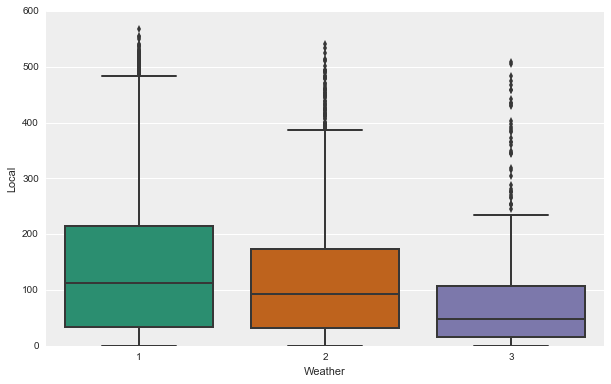

In [13]:
#Weather
sns.boxplot(local['Weather'],local['Local'])

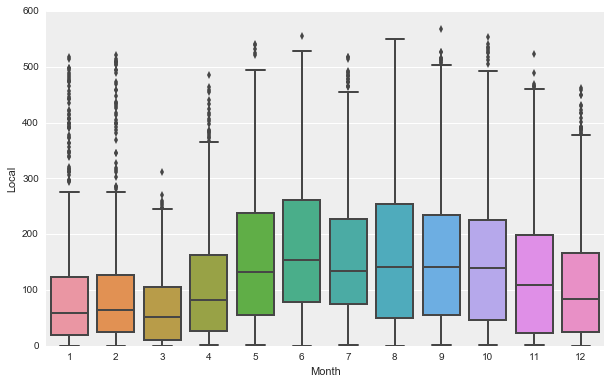

In [14]:
#Month
sns.boxplot(local['Month'],local['Local'])
for data in df_local:
    for index,row in data.iterrows():
        y = row['Month']
        if(y==1 or y==2):
            s = 1
        if(y==3):
            s = 2
        if(y==4 or y==12):
            s = 3
        if(y==5 or y==8 or y==9 or y==10):
            s = 4
        if(y==6):
            s = 5
        if(y==7):
            s = 6
        if(y==11):
            s = 7
        data.set_value(index,'Month',s)

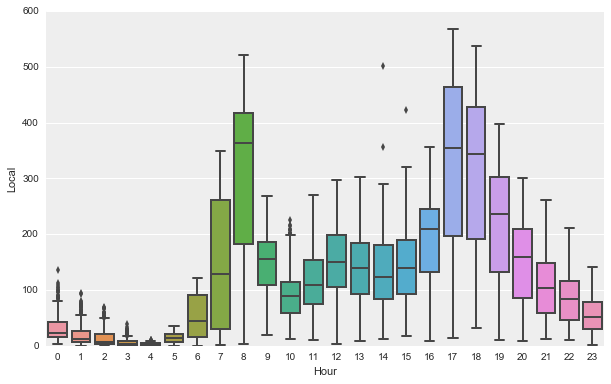

In [15]:
#Hour
sns.boxplot(local['Hour'],local['Local'])

Date Median
1 99.0
2 96.0
3 96.0
4 105.0
5 86.0
6 96.0
7 96.0
8 95.0
9 105.0
10 110.0
11 96.0
12 101.0
13 99.0
14 107.0
15 99.5
16 81.0
17 110.0
18 124.0
19 98.0
20 107.5
21 93.0
22 80.0
23 89.5
24 88.0
25 101.0
26 94.0
27 94.5
28 115.0
29 97.5
30 109.0
31 101.0


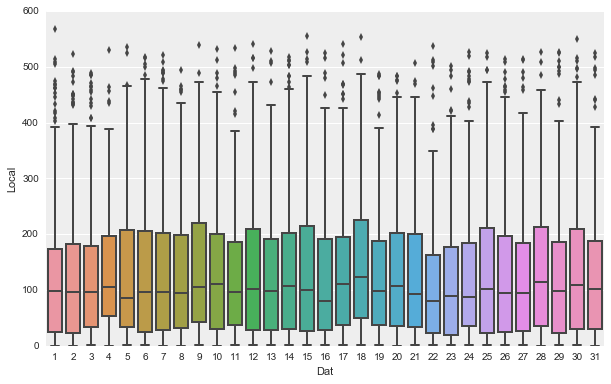

In [16]:
#Date
sns.boxplot(local['Dat'],local['Local'])
print "Date Median"
for i in range(1,32):
    print i,local[local['Dat']==i]['Local'].describe()['50%']
for data in df_local:
    for index,row in data.iterrows():
        y = row['Dat']
        if(y==1 or y==12 or y==13 or y==15 or y==19 or y==25 or y==29 or y==31): #99
            s = 1
        if(y==2 or y==3 or y==6 or y==7 or y==8 or y==11 or y==21 or y==26 or y==27): #96
            s = 2
        if(y==4 or y==9 or y==14 or y==20): #105
            s = 3
        if(y==5 or y==16 or y==22 or y==23 or y==24): #80s
            s = 4
        if(y==10 or y==17 or y==30): #110
            s = 5
        if(y==18 or y==28):
            s = 6
        data.set_value(index,'Dat',s)

Median Mean
86.0 108.464566929
97.0 138.318655852
110.0 151.684210526
101.0 139.197038724
104.0 143.458628842
108.5 139.6558753
88.0 108.969866071


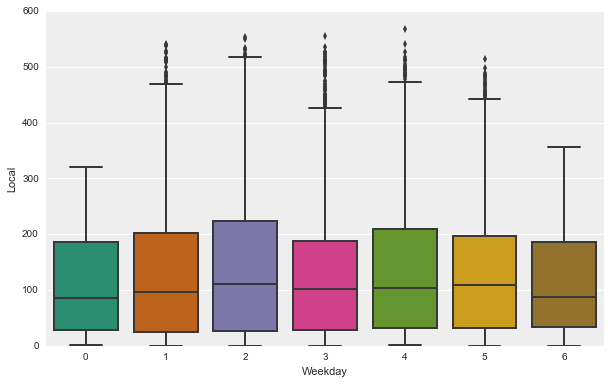

In [17]:
#Weekday
sns.boxplot(local['Weekday'],local['Local'])
print "Median Mean"
for i in range(0,7):
    print local[local['Weekday']==i]['Local'].describe()['50%'],local[local['Weekday']==i]['Local'].describe()['mean']
for data in df_local:
    for index,row in data.iterrows():
        y = row['Weekday']
        if(y in [0,6]):
            s = 0
        if(y in [1,3]):
            s = 1
        if(y==2):
            s = 2
        if(y in [4,5]):
            s = 3
        data.set_value(index,'Weekday',s)

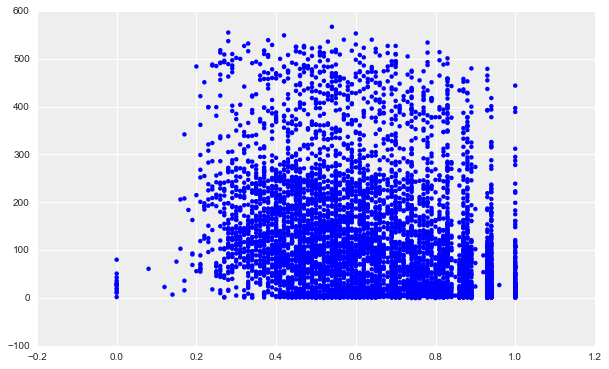

In [18]:
#Fog Density
plt.scatter(local['Fog Density'],local['Local'])

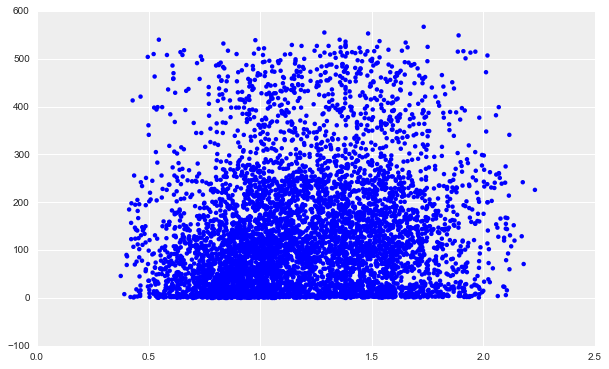

In [19]:
#Humidity
plt.scatter(local['Humidity'],local['Local'])

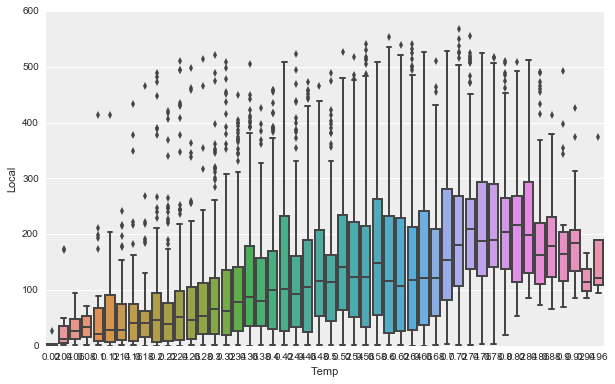

In [20]:
#Temp
sns.boxplot(local['Temp'],local['Local'])
#plt.scatter(local['temp_diff'],local['Local'])

Cross-Validation Score on Jan 2012: 77.975148
5 fold Cross-Validation Score: 58.645568


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


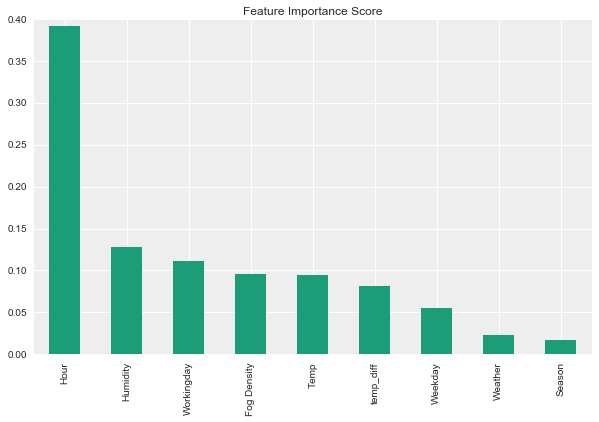

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score
dtrain = local[local['Year']==0] #2011
dtest = local[local['Year']==1] #2012
var = ['Season','Hour','Weekday','Workingday','Weather','Temp','Fog Density','Humidity','temp_diff']
rf = GradientBoostingRegressor(learning_rate=0.2,n_estimators=100,min_samples_split=30,min_samples_leaf=10,max_depth=3,subsample=0.8)
rf.fit(dtrain[var],dtrain['Local'])
rf_final = GradientBoostingRegressor(learning_rate=0.2,n_estimators=100,min_samples_split=30,min_samples_leaf=10,max_depth=3,subsample=0.8)
rf_final.fit(local[var],local['Local'])
feat_imp = pd.Series(rf.feature_importances_,var).sort_values(ascending=False)
feat_imp.plot(kind='bar',title='Feature Importance Score')
pred_local = rf.predict(dtest[var])
predl_final = rf_final.predict(local_test[var])
c = 0
i = 0
for index,row in dtest.iterrows():
    if(pred_local[i]<0):
        c = c + (row['Local'])**2
    else:
        c = c + (pred_local[i]-row['Local'])**2
    i = i + 1
print "Cross-Validation Score on Jan 2012: %f"%(math.sqrt(c/i))
print "5 fold Cross-Validation Score: %f"%(math.sqrt((-1)*np.mean(cross_val_score(rf,local[var],local['Local'],cv=5,scoring='neg_mean_squared_error'))))

## Foreign Visitors

In [22]:
foreign = train.copy()
foreign.drop(['Local','Total Visitors'],axis=1,inplace=True)
foreign_test = test.copy()

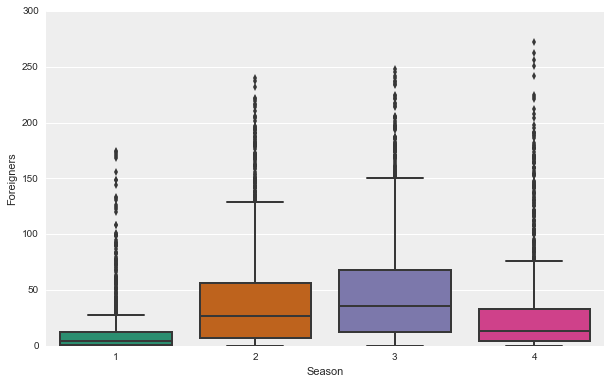

In [23]:
#Season
sns.boxplot(foreign['Season'],foreign['Foreigners'])

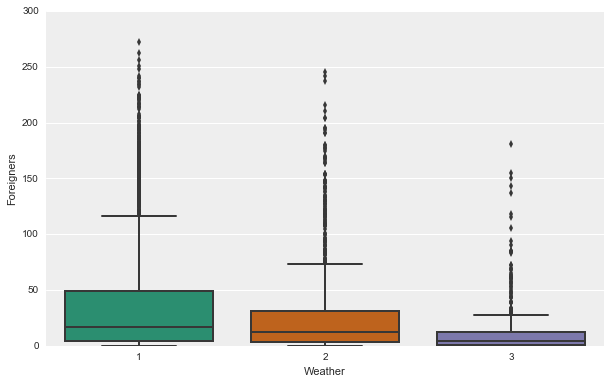

In [24]:
#Weather
sns.boxplot(foreign['Weather'],foreign['Foreigners'])

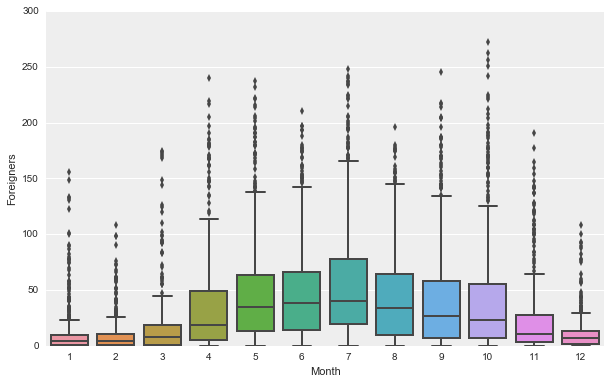

In [25]:
#Month
sns.boxplot(foreign['Month'],foreign['Foreigners'])
df_foreign = [foreign,foreign_test]
for data in df_foreign:
    for index,row in data.iterrows():
        y = row['Month']
        if(y==1 or y==2 or y==12):
            s = 1
        if(y==3):
            s = 2
        if(y==4):
            s = 3
        if(y==5 or y==6 or y==8):
            s = 4
        if(y==7):
            s = 5
        if(y==9 or y==10):
            s = 6
        if(y==11):
            s = 7
        data.set_value(index,'Month',s)

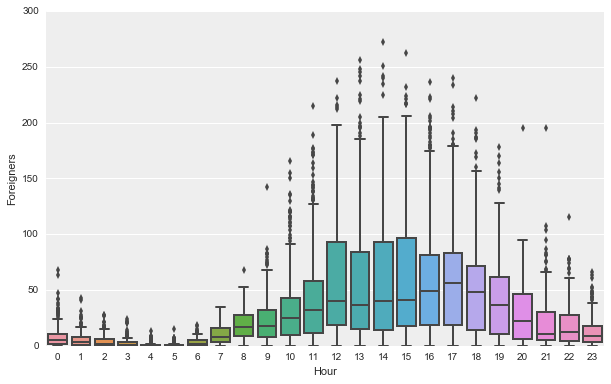

In [26]:
#Hour
sns.boxplot(foreign['Hour'],foreign['Foreigners'])

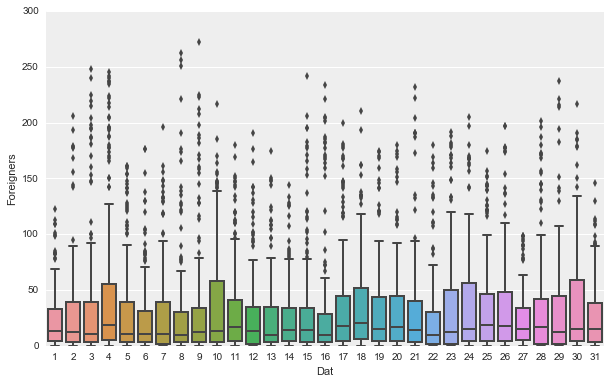

In [27]:
#Date
sns.boxplot(foreign['Dat'],foreign['Foreigners'])

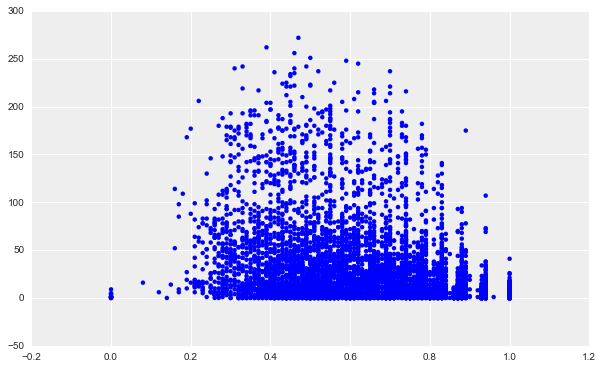

In [28]:
#Fog Density
plt.scatter(foreign['Fog Density'],foreign['Foreigners'])

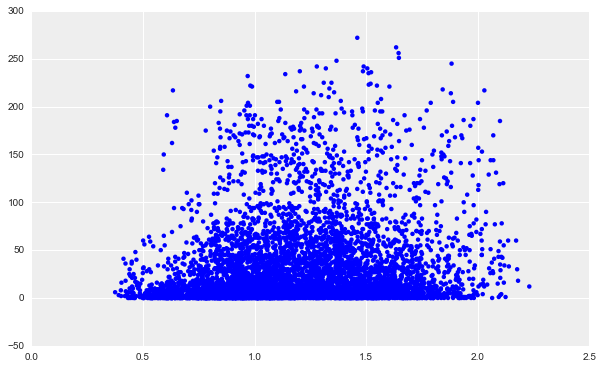

In [29]:
#Humidity
plt.scatter(foreign['Humidity'],foreign['Foreigners'])

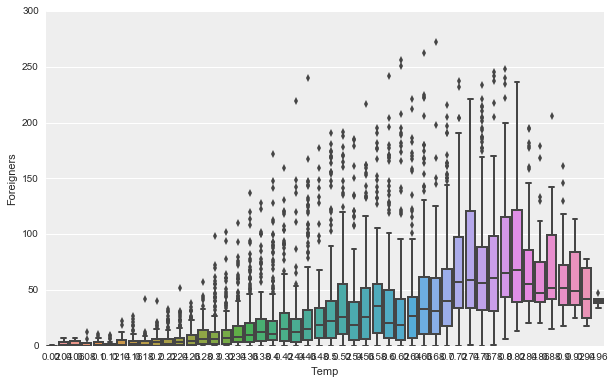

In [30]:
#Temp
sns.boxplot(foreign['Temp'],foreign['Foreigners'])

Cross-Validation Score on Jan 2012: 9.987473
5 fold Cross-Validation Score: 19.185952


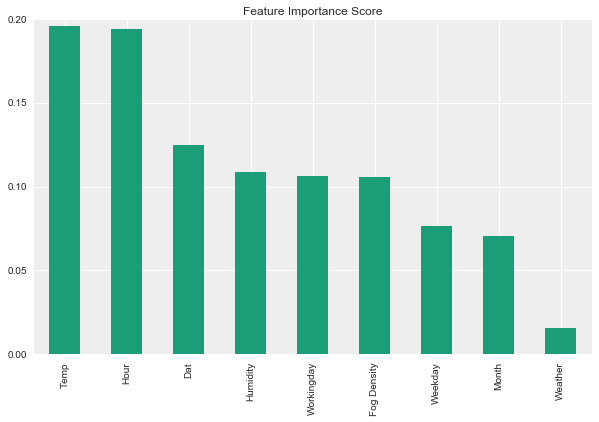

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score
dtrain = foreign[foreign['Year']==0] #2011
dtest = foreign[foreign['Year']==1] #2012
var = ['Hour','Weekday','Workingday','Weather','Temp','Fog Density','Humidity','Dat','Month']
rf = GradientBoostingRegressor(learning_rate=0.09,n_estimators=100,subsample=0.8,max_depth=6,min_samples_split=50,min_samples_leaf=40)
rf.fit(dtrain[var],dtrain['Foreigners'])
rf_final = GradientBoostingRegressor(learning_rate=0.09,n_estimators=100,subsample=0.8,max_depth=6,min_samples_split=50,min_samples_leaf=40)
rf_final.fit(foreign[var],foreign['Foreigners'])
feat_imp = pd.Series(rf.feature_importances_,var).sort_values(ascending=False)
feat_imp.plot(kind='bar',title='Feature Importance Score')
pred_foreign = rf.predict(dtest[var])
predf_final = rf_final.predict(foreign_test[var])
c = 0
i = 0
for index,row in dtest.iterrows():
    if(pred_foreign[i]<0):
        c = c + (row['Foreigners'])**2
    else:
        c = c + (pred_foreign[i]-row['Foreigners'])**2
    i = i + 1
print "Cross-Validation Score on Jan 2012: %f"%(math.sqrt(c/i))
print "5 fold Cross-Validation Score: %f"%(math.sqrt((-1)*np.mean(cross_val_score(rf,foreign[var],foreign['Foreigners'],cv=5,scoring='neg_mean_squared_error'))))

In [32]:
#Cross-Validation of Total Visitors
dtest_total = train[train['Year']==1] #2012
c = 0
i = 0
for index,row in dtest_total.iterrows():
    c = c + (pred_local[i]+pred_foreign[i]-row['Total Visitors'])**2
    i = i + 1
print math.sqrt(c/i)

81.8810463539


In [33]:
def maxi(a,b):
    if(a>b):
        return a
    else:
        return b
test['Total'] = -1
i = 0
for index,row in test.iterrows():
    c = int(round(maxi(0,predl_final[i]) + maxi(0,predf_final[i])))
    test.set_value(index,'Total',c)
    i = i + 1
test.to_csv('Output.csv',columns=('Unnamed: 0','Total'),index=False)

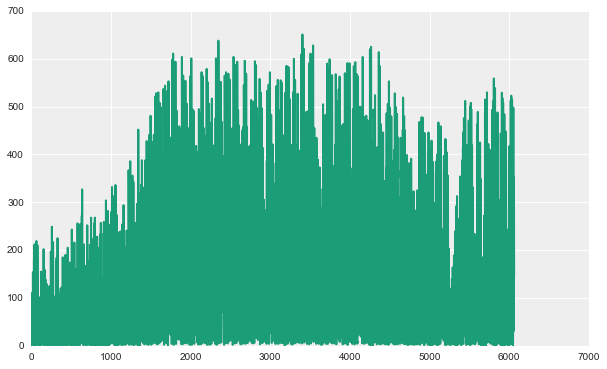

In [34]:
plt.plot(train['Total Visitors'])

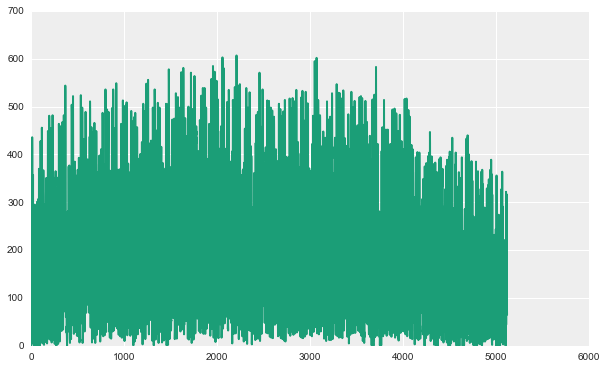

In [35]:
plt.plot(test['Total'])